# 1.0 Introduction

The Full-Width Half Maximum (FWHM) of a diffraction peak varies with the level of ordering within a crystal. This allows the FWHM to be used as a metric to distinguish amorphous alloys from crystalline alloys.

Metallic glasses are amorphous and thus, FWHM measurement can be used to predict the glass-forming ability of alloys.

This report trains various linear regression models on FWHM measurements of three ternary subsystems (CrTiZr, CrCoZr, CoTiZr) which constitute the quaternery Co-Zr-Cr-Ti system, in order to investigate this quaternery system's glass-forming ability.

# 2.0 Data Exploration

In [1]:
# Import standard libraries
import pandas as pd
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker
import matplotlib.patches as patches

import scipy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, KFold, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score

from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema, YangSolidSolution

In [2]:
rng = 0

In [3]:
# Loading each ternery system as a separate dataframe, adding a "Group" label to each alloy
# https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html
CrTiZr_data = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = 0)
CrTiZr_data = CrTiZr_data.dropna(axis=1)
CrTiZr_data['Group'] = 1
CrCoZr_data = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = 1)
CrCoZr_data = CrCoZr_data.dropna(axis=1)
CrCoZr_data['Group'] = 2
CoTiZr_data = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = 2)
CoTiZr_data = CoTiZr_data.dropna(axis=1)
CoTiZr_data['Group'] = 3

In [4]:
# Combine dataframes into one 
def combine_dataframes(df1, df2):
    common_columns = list(set(df1.columns) & set(df2.columns))
    # Merge dataframes on the common columns
    # https://sparkbyexamples.com/pandas/pandas-outer-join-explained-by-examples/#:~:text=Outer%20join%20is%20also%20called,returns%20null%20on%20respective%20cells.
    df_merged = pd.merge(df1, df2, on=common_columns, how='outer')
    # Put zeros for missing values
    df_merged.fillna(0, inplace=True)
    return df_merged

In [5]:
combined_data = combine_dataframes(CrTiZr_data, CrCoZr_data)
combined_data = combine_dataframes(CoTiZr_data, combined_data)
combined_data = combined_data[['Co', 'Ti', 'Zr','Cr','MaxFWHM', 'Group']]

In [6]:
# Data preparation
combined_data = combined_data.dropna()
combined_data = combined_data.drop_duplicates()
combined_data.head(2)

,Co,Ti,Zr,Cr,MaxFWHM,Group
0,0.048418,0.216790,0.734792,0.0,0.433848,3
1,0.054623,0.267908,0.677469,0.0,0.405630,3


In [7]:
combined_data.corr().iloc[:4,:4] > abs(0.8)

,Co,Ti,Zr,Cr
Co,True,False,False,False
Ti,False,True,False,False
Zr,False,False,True,False
Cr,False,False,False,True


None of the features are highly correlated - as such none are dropped

## 2.0.1 Helper Functions

In [8]:
import ternary

# Ternary plot function
def plot_ternary(data, components, z, label, title=''):
    
    fig, ax = plt.subplots()
    
    scale = 100

    grid = plt.GridSpec(10, 10, wspace=2, hspace=1)
    ax = plt.subplot(grid[:,:9])
    
    figure, tax = ternary.figure(scale=scale, ax=ax)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="blue", multiple=10)

    # Set Axis labels and Title
    fontsize = 12
    offset = 0.14
    tax.right_corner_label(components[0], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.top_corner_label(components[2], fontsize=fontsize, offset=0.23, fontweight='bold')
    tax.left_corner_label(components[1], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.left_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.right_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025, clockwise= True)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    
    
    # Create color map and plot color bar
    cmap = plt.cm.nipy_spectral
    norm = plt.Normalize(0, z.max())
    
    tax.scatter(data, marker='o', c=cmap(norm(z)), edgecolors='k', alpha=1, s=30, vmin=z.min(), vmax=z.max())
    
    ax = plt.subplot(grid[1:-1,9:])
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', label=label)
    cb1.set_label(label=label, size=18)

In [9]:
# Wrote the function myself, asked ChatGPT to write the docstring
def cross_validate(x, y, cvtype=None):
    """
    Perform cross validation with standardization per each fold.
    
    Parameters:
        x (pandas.DataFrame): The feature data, with rows representing samples and columns representing features.
        y (numpy.ndarray): The target variable data, with one value for each sample.
        cvtype (str): The type of cross-validation to use. Valid options are "random" for random sampling, and "LOCO" 
            for leave-one-group-out cross-validation. Default is None.
    
    Returns:
        Tuple: A tuple containing the following elements:
            - A dictionary with R^2 scores and MSE values for the training and testing sets.
            - An array of predicted target values for the training set.
            - An array of predicted target values for the testing set.
            - An array of true target values for the testing set.
            - An array of true target values for the training set.
    """
    X = x 
    y = y 
    
    if cvtype is None:
        raise ValueError("You must specify the type of cross-validation to use.")
        return
       
    elif cvtype == "random":
        cv_type = ShuffleSplit(n_splits=5, test_size=0.2, random_state=rng)
        cv_type = cv_type.split(X)
    
    elif cvtype == "LOCO":
        cv_type = LeaveOneGroupOut()
        cv_type = cv_type.split(X, groups=combined_data['Group'])
    
    # Track R^2 values on test and training sets
    test_scores = [] 
    train_scores = []
    
    for train_ix, test_ix in cv_type:
        X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
        y_train, y_test = y[train_ix], y[test_ix]

        scaler = StandardScaler()
        model = LinearRegression()

        # Standardize features
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train model
        model.fit(X_train_scaled, y_train)
        train_scores.append(model.score(X_train_scaled, y_train))

        # Predict
        y_test_pred = model.predict(X_test_scaled)
        test_scores.append(model.score(X_test_scaled, y_test))    

        # Calculate training and validation errors
        y_train_pred = model.predict(X_train_scaled) # Predicted FWHM from training set compositions
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_val = mean_squared_error(y_test, y_test_pred)
        
    performance_summary = {'Training set R2 scores' : train_scores,
                          'Test set R2 scores' : test_scores,
                          'Training MSE': round(mse_train,6),
                          'Testing MSE': round(mse_val,6)}
        
    return performance_summary, y_train, y_train_pred, y_test, y_test_pred

In [10]:
# Function created using ChatGPT
def parity_plot(y_true, y_pred, title=None):
    """
    Create a parity plot of data predicted by a linear regression model.
    
    Args:
        y_true (array-like): The true y values of the data.
        y_pred (array-like): The predicted y values of the data.
        title (str, optional): The title of the graph. Defaults to None.
    """
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.5)
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([0, max_val], [0, max_val], color='red', linestyle='--')
    ax.set_xlabel('True FWHM Values')
    ax.set_ylabel('Predicted FWHM Values')
    r2 = r2_score(y_true, y_pred)
    if title is not None:
        ax.set_title(title + ' (R$^2$={:.3f})'.format(r2))
    else:
        ax.set_title('Parity Plot (R$^2$={:.3f})'.format(r2))
    plt.show()

In [11]:
# Create a graph of y vs sample number
def visualise_predictions(y_test, y_hat, title=None):
    figure(figsize=(6,4), dpi=80)
    plt.scatter(range(len(y_test)), y_test, color='skyblue', label='True values')
    plt.scatter(range(len(y_test)), y_hat, color='orangered', marker='x', label='Predicted values')
    plt.xlabel('Sample number')
    plt.ylabel('FWHM Value')
    plt.legend()
    if title is not None:
        plt.title(title)
#     plt.show()

## 2.0 Composition-based model: predicting FWHM using composition only

### 2.1 Testing model generalizability by performing cross validation

#### 2.1.1 Performing LOCO-CV by splitting the dataset by ternary systems

Training set R2 scores:
[0.1529836610068851, 0.43710120330382396, 0.653392621504425]
Test set R2 scores:
[-1.0977536881875376, -4.611784337923232, -36.22945730718377]
Training MSE:
0.00952
Testing MSE:
0.495588


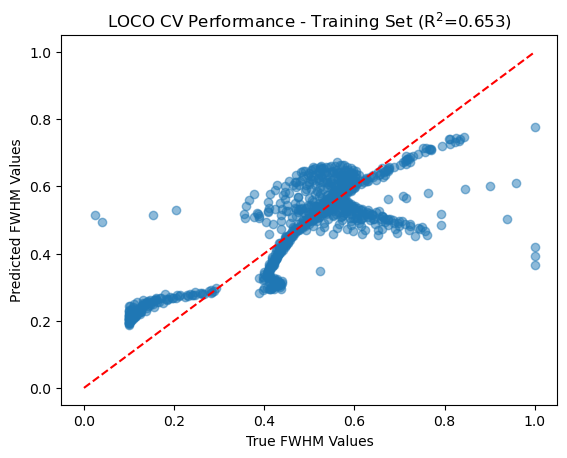

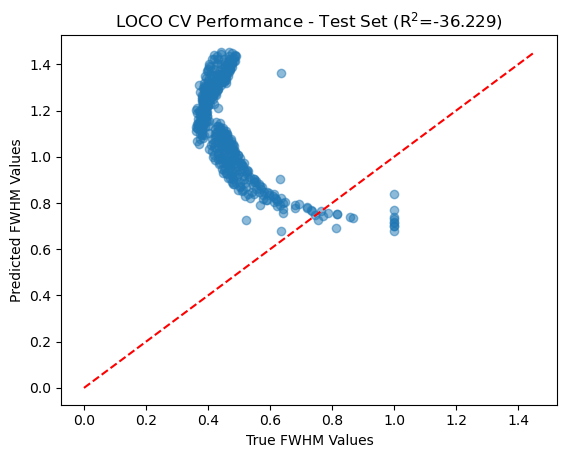

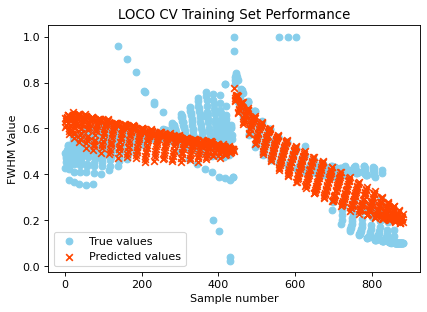

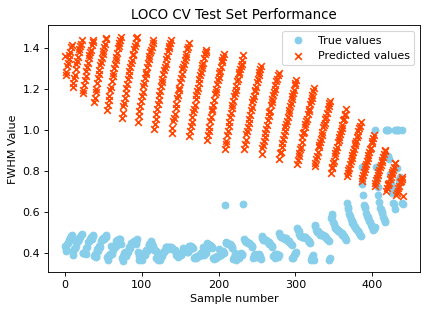

In [12]:
X = combined_data.iloc[:,0:4].astype(float) #Atomic fractions
y = combined_data.iloc[:,4].astype(float) # FWHM values

comploco_performance_summary, y_train, y_train_pred, y_test, y_test_pred = cross_validate(X,y,cvtype="LOCO")

# Display cross-validation statistics
for key, value in comploco_performance_summary.items():
    print(f"{key}:")
    print(value)
    
# Plot parity plots for training and test set performance
parity_plot(y_train, y_train_pred, title="LOCO CV Performance - Training Set")
parity_plot(y_test, y_test_pred, title="LOCO CV Performance - Test Set")

# Graph model predictions vs 
visualise_predictions(y_train, y_train_pred,title="LOCO CV Training Set Performance")
visualise_predictions(y_test, y_test_pred, title="LOCO CV Test Set Performance")

#### 2.1.1 Performing random (KFold) CV

Training set R2 scores:
[0.21750797803201083, 0.22517049717345117, 0.22570886555851077, 0.2243967463593236, 0.20811256667580713]
Test set R2 scores:
[0.19109136834204887, 0.15297169580819692, 0.1411462388424426, 0.16109826897622115, 0.22211878044776479]
Training MSE:
0.017638
Testing MSE:
0.019344


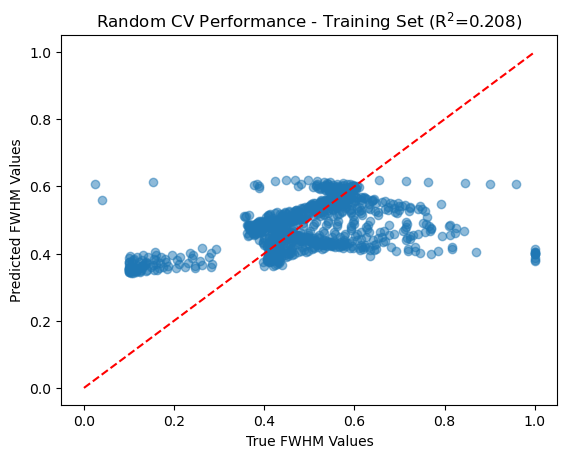

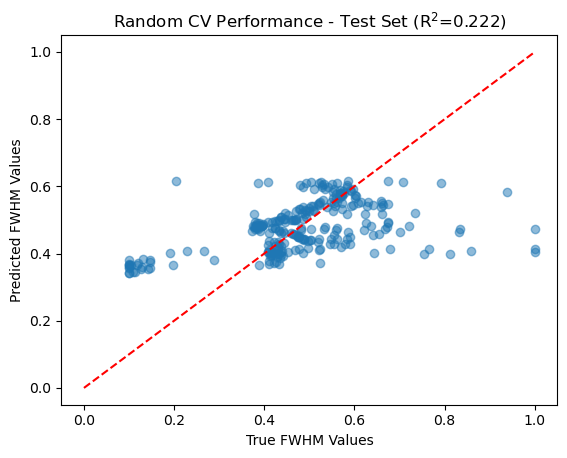

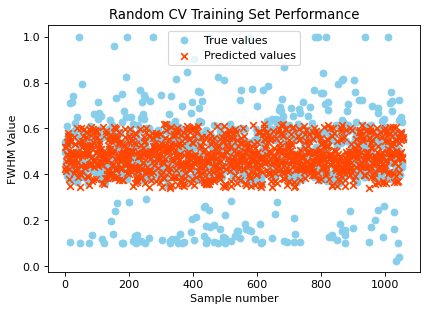

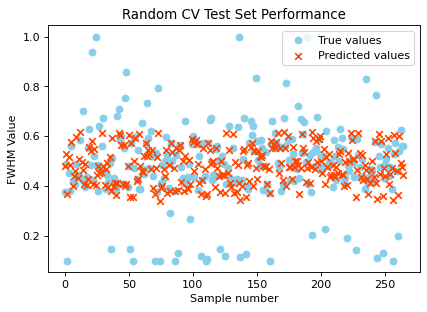

In [13]:
X = combined_data.iloc[:,0:4].astype(float) #Atomic fractions
y = combined_data.iloc[:,4].astype(float) # FWHM values

comprandom_performance_summary, y_train, y_train_pred, y_test, y_test_pred = cross_validate(X,y,cvtype="random")

# Display cross-validation statistics
for key, value in comprandom_performance_summary.items():
    print(f"{key}:")
    print(value)
    
# Plot parity plots for training and test set performance
parity_plot(y_train, y_train_pred, title="Random CV Performance - Training Set")
parity_plot(y_test, y_test_pred, title="Random CV Performance - Test Set")

# Graph model predictions vs 
visualise_predictions(y_train, y_train_pred,title="Random CV Training Set Performance")
visualise_predictions(y_test, y_test_pred, title="Random CV Test Set Performance")

## 2.2 Training a full-data composition model

In [14]:
full_X = combined_data.iloc[:,0:4].astype(float) #Atomic fractions
full_y = combined_data.iloc[:,4].astype(float) # FWHM values

full_data_comp_model_scaler = StandardScaler()
full_data_comp_model = LinearRegression()

# Standardize features
full_X = full_data_comp_model_scaler.fit_transform(full_X)
# Train model
full_data_comp_model.fit(full_X, full_y)

LinearRegression()

# 3.0 Featurized data-based model

## 3.1 Featurize the dataset

Using Miedema potential and Yang Solid Solution as additional features:


In [15]:
# Add chemical formula column to facilitate featurization with matminer
featurized_data = combined_data
formula = 'Co'+combined_data['Co'].astype(str)+'Ti'+combined_data['Ti'].astype(str)+'Zr'+combined_data['Zr'].astype(str)+'Cr'+combined_data['Cr'].astype(str)
featurized_data['Formula'] = pd.DataFrame(formula)
featurized_data = featurized_data[['Formula', 'Co', 'Ti', 'Zr','Cr','MaxFWHM', 'Group']]

In [16]:
#convert the formula from a string into chemical composition
featurized_data = StrToComposition().featurize_dataframe(featurized_data, "Formula")
featurized_data = Miedema().featurize_dataframe(featurized_data, col_id="composition")
featurized_data = YangSolidSolution().featurize_dataframe(featurized_data, col_id="composition")

StrToComposition:   0%|          | 0/1323 [00:00<?, ?it/s]

Miedema:   0%|          | 0/1323 [00:00<?, ?it/s]

YangSolidSolution:   0%|          | 0/1323 [00:00<?, ?it/s]

In [17]:
# rearrange data for easier processing
featurized_data_rearranged = featurized_data
featurized_data_rearranged = featurized_data_rearranged[['Formula','composition','Co', 'Ti', 'Zr', 'Cr','Miedema_deltaH_inter',
                                                         'Miedema_deltaH_amor','Miedema_deltaH_ss_min','Yang omega',
                                                         'Yang delta','MaxFWHM', 'Group']]

## 3.2 Testing model generalizability by performing cross validation

### 3.2.1 Performing LOCO-CV by splitting the featurized dataset by ternary systems

Training set R2 scores:
[0.80215535205756, 0.6802026982688278, 0.8254511754756739]
Test set R2 scores:
[-0.3298422694670322, -16.539562504008774, -144.92916066474783]
Training MSE:
0.004794
Testing MSE:
1.942566


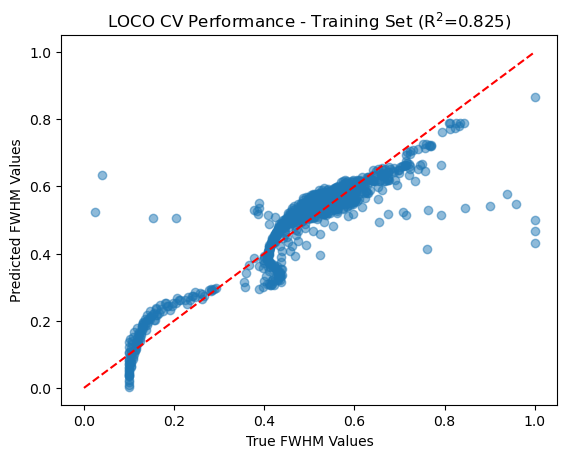

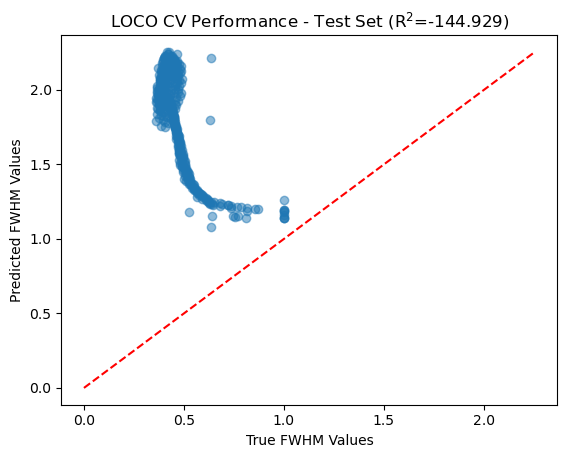

In [19]:
X = featurized_data_rearranged.iloc[:,2:11].astype(float) #Atomic fractions
y = featurized_data_rearranged.iloc[:,11].astype(float) # FWHM values

featurized_loco_performance_summary, y_train, y_train_pred, y_test, y_test_pred = cross_validate(X,y,cvtype="LOCO")

# Display cross-validation statistics
for key, value in featurized_loco_performance_summary.items():
    print(f"{key}:")
    print(value)
    
# Plot parity plots for training and test set performance
parity_plot(y_train, y_train_pred, title="LOCO CV Performance - Training Set")
parity_plot(y_test, y_test_pred, title="LOCO CV Performance - Test Set")

# Graph model predictions vs true values
# visualise_predictions(y_train, y_train_pred,title="LOCO CV Training Set Performance")
# visualise_predictions(y_test, y_test_pred, title="LOCO CV Test Set Performance")

### 3.2.2 Performing Random CV

Training set R2 scores:
[0.7620279849741727, 0.7610378266151895, 0.7555829178402447, 0.7548929072766398, 0.7562622951968097]
Test set R2 scores:
[0.755387823109347, 0.7571513192779247, 0.7826609960638349, 0.7814439143717197, 0.7755420717425044]
Training MSE:
0.005429
Testing MSE:
0.005582


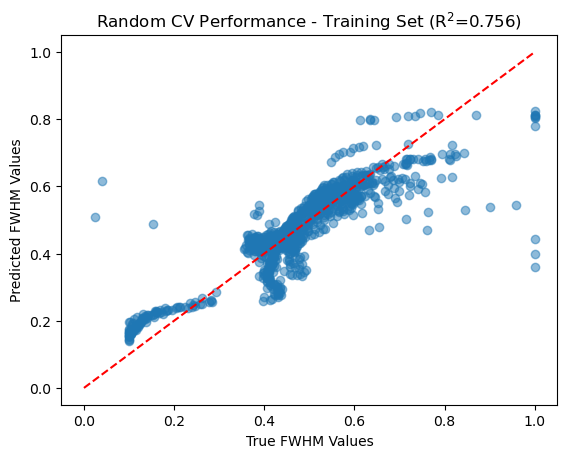

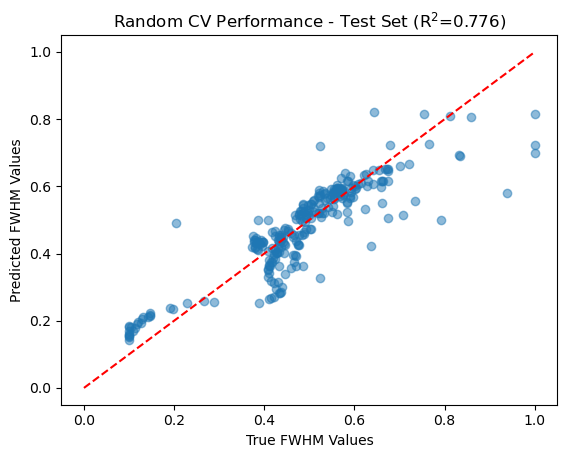

In [20]:
X = featurized_data_rearranged.iloc[:,2:11].astype(float) #Atomic fractions
y = featurized_data_rearranged.iloc[:,11].astype(float) # FWHM values

featurized_random_performance_summary, y_train, y_train_pred, y_test, y_test_pred = cross_validate(X,y,cvtype="random")

# Display cross-validation statistics
for key, value in featurized_random_performance_summary.items():
    print(f"{key}:")
    print(value)
    
# Plot parity plots for training and test set performance
parity_plot(y_train, y_train_pred, title="Random CV Performance - Training Set")
parity_plot(y_test, y_test_pred, title="Random CV Performance - Test Set")

# Graph model predictions vs true values
# visualise_predictions(y_train, y_train_pred,title="Random CV Training Set Performance")
# visualise_predictions(y_test, y_test_pred, title="Random CV Test Set Performance")

## 3.3 Training a full featurized data model

In [21]:
featurized_data_rearranged = featurized_data
featurized_data_rearranged = featurized_data_rearranged[['Formula','composition','Co', 'Ti', 'Zr', 'Cr','Miedema_deltaH_inter',
                                                         'Miedema_deltaH_amor','Miedema_deltaH_ss_min','Yang omega',
                                                         'Yang delta','MaxFWHM', 'Group']]
X = featurized_data_rearranged.iloc[:,2:11].astype(float)

y = featurized_data_rearranged.iloc[:,11].astype(float) # FWHM values

full_data_featurized_scaler = StandardScaler()
full_data_featurized_model = LinearRegression()

# Standardize features
full_X = full_data_featurized_scaler.fit_transform(X)
# Train model
full_data_featurized_model.fit(full_X, y)

LinearRegression()

# 4.0 Predicting the FWHM for the entire Co-Zr-Cr-Ti quaternary phase diagram (5 at.% increments) using both full composition and matminer full data models

Creating a Co-Zr-Cr-Ti dataframe representing atomic compositions of a quantenary alloy, using 5at% increments:

In [22]:
# Used ChatGPT
# Define the elements of the alloy
elements = ['Co', 'Ti', 'Zr', 'Cr']

# Define the increment for atomic fractions
increment = 0.05

# Create an empty list to store the rows of the DataFrame
rows = []

# Generate all possible combinations of atomic fractions
for i in range(0, 21):
    for j in range(0, 21):
        for k in range(0, 21):
            # Compute the atomic fraction for the last element
            l = 20 - i - j - k
            if l < 0:
                continue
            # Compute the atomic fractions for each element
            atomic_fractions = [i*increment, j*increment, k*increment, l*increment]
            # Check if the total atomic fraction is equal to 1
            total_atomic_fraction = sum(atomic_fractions)
            if total_atomic_fraction == 1:
                rows.append(atomic_fractions)

# Create a DataFrame from the list of rows
quaternary_data = pd.DataFrame(rows, columns=elements)

In [23]:
# poly = PolynomialFeatures(degree=2)
# df = poly.fit_transform(df)
formula = 'Co'+quaternary_data['Co'].astype(str)+'Ti'+quaternary_data['Ti'].astype(str)+'Zr'+quaternary_data['Zr'].astype(str)+'Cr'+quaternary_data['Cr'].astype(str)
quaternary_data['Formula'] = pd.DataFrame(formula)
quaternary_data = quaternary_data[['Formula', 'Co', 'Ti', 'Zr','Cr']]
quaternary_data = StrToComposition().featurize_dataframe(quaternary_data, "Formula")
quaternary_data = Miedema().featurize_dataframe(quaternary_data, col_id="composition")
quaternary_data = YangSolidSolution().featurize_dataframe(quaternary_data, col_id="composition")

StrToComposition:   0%|          | 0/1584 [00:00<?, ?it/s]

Miedema:   0%|          | 0/1584 [00:00<?, ?it/s]

YangSolidSolution:   0%|          | 0/1584 [00:00<?, ?it/s]

In [24]:
quaternary_data_rearranged = quaternary_data[['Formula','composition','Co', 'Ti', 'Zr', 'Cr','Miedema_deltaH_inter',
                                                         'Miedema_deltaH_amor','Miedema_deltaH_ss_min','Yang omega',
                                                         'Yang delta']]

In [25]:
composition_model_X = quaternary_data_rearranged.iloc[:,2:6].astype(float)
matminer_model_X = quaternary_data_rearranged.iloc[:,2:].astype(float)

In [26]:
# Standardize test data (0.05 increment compositions) using training data (ternery compositions)
composition_model_X = full_data_comp_model_scaler.transform(composition_model_X)
matminer_model_X = full_data_featurized_scaler.transform(matminer_model_X.values)

C:\Users\karth\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [27]:
predictions_matminer_model = full_data_featurized_model.predict(matminer_model_X)
predictions_comp_model = full_data_comp_model.predict(composition_model_X)

In [28]:
final_data = X[['Co','Ti','Zr','Cr','Yang omega','Yang delta']]

In [29]:
final_data['Matminer Model FWHM'] = pd.DataFrame(predictions_matminer_model)
final_data['Composition Model FWHM'] = pd.DataFrame(predictions_comp_model)

C:\Users\karth\AppData\Local\Temp\ipykernel_12344\1434949714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Matminer Model FWHM'] = pd.DataFrame(predictions_matminer_model)
C:\Users\karth\AppData\Local\Temp\ipykernel_12344\1434949714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Composition Model FWHM'] = pd.DataFrame(predictions_comp_model)


In [31]:
def percent_fmt(x, pos):
    return f"{x*100:.0f}%"

# Used ChatGPT and modified code
def plot_dataframe(df, color_col):
    # Extract the x, y, and color values from the DataFrame
    x = df.iloc[:, 5]
    y = df.iloc[:, 4]
    c = df[color_col]
    
    # Create a scatter plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=c)
    
    # Add labels and a color bar
    ax.set_xlabel(df.columns[5])
    ax.set_ylabel(df.columns[4])
    cbar = fig.colorbar(ax.collections[0])
    cbar.set_label(color_col)  # Add label to the color bar
    
    # Format the x-axis as percentages
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(percent_fmt))

    # Show the plot
    plt.title(f"Yang Plot of {color_col} values")
    plt.show()


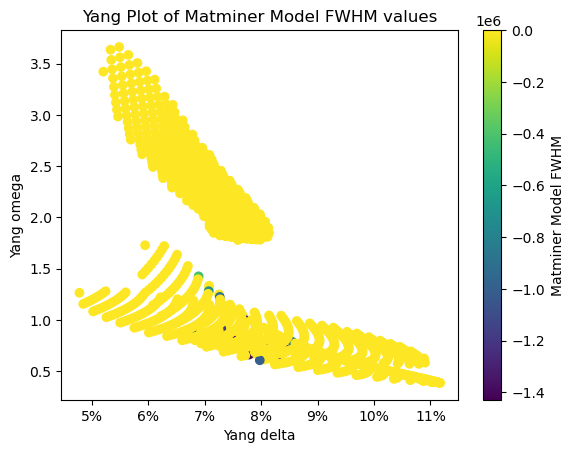

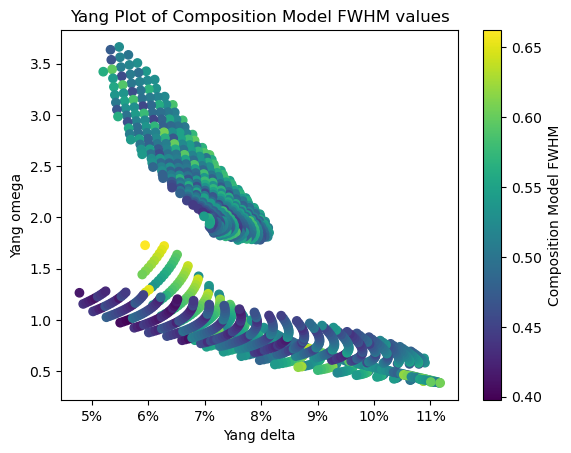

In [32]:
plot_dataframe(final_data, "Matminer Model FWHM")
plot_dataframe(final_data, "Composition Model FWHM")

The Matminer Model Yang Plot is very difficult to interpret. Upon closer inspection of the FWHM predicted by my Matminer model, it seems like majority of the values are indeed between 0 and 1 - just a few errant outliers are causing the extreme 1e7 and negative bounds of the color bar. __For this reason, these Yang plots are replotted below, with only data points having FWHM values greater than 0 being visible__:

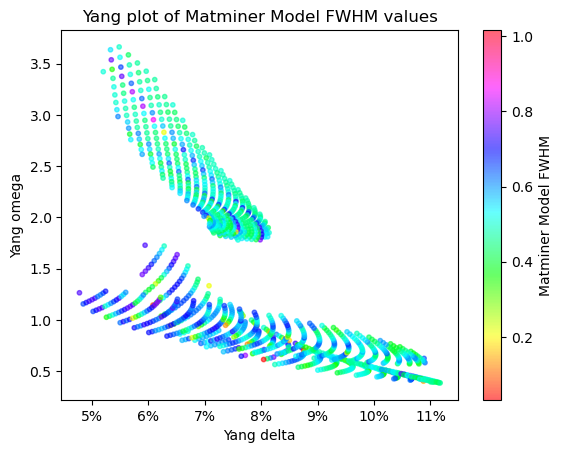

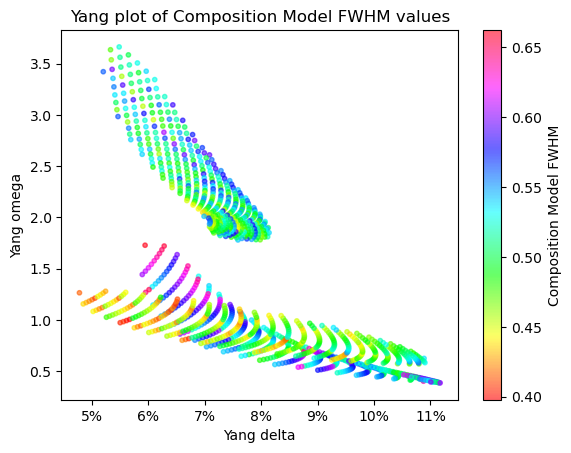

In [33]:
def percent_fmt(x, pos):
    return f"{x*100:.0f}%"

# Used ChatGPT and made modifications
def plot_dataframe(df, color_col, threshold=None, overlay_rect=False):
    # Filter the DataFrame to include only rows with a positive color_col value
    df_filtered = df[df[color_col] > 0]
    
    # Extract the x, y, and color values from the filtered DataFrame
    x = df_filtered.iloc[:, 5]
    y = df_filtered.iloc[:, 4]
    c = df_filtered[color_col]
    
    # Create a scatter plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=c, cmap='hsv', s=10, alpha=0.6)
    
    # Highlight points above the threshold value
    if threshold is not None:
        above_threshold = df_filtered[color_col] > threshold
        ax.scatter(x[above_threshold], y[above_threshold], c='red', s=20, alpha=1)
        num_above_threshold = above_threshold.sum()
        # Add caption
        caption = f"{num_above_threshold} points above threshold"
        ax.text(0.5, -0.2, caption, transform=ax.transAxes, ha='center')
    
    # Add labels and a color bar
    ax.set_xlabel(df.columns[5])
    ax.set_ylabel(df.columns[4])
    cbar = fig.colorbar(ax.collections[0])
    cbar.set_label(color_col)
    
    # Format the x-axis as percentages
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(percent_fmt))
    
    # Set the y-axis scale to logarithmic
#     ax.set_yscale('log')
    
    # Draw a rectangle on the plot representing Yang heuristic
    if overlay_rect:
        rect = patches.Rectangle((0.05, 0.3), 0.13, 1.2, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
    
    # Show the plot
    plt.title(f"Yang plot of {color_col} values")
    plt.show()
plot_dataframe(final_data, "Matminer Model FWHM")
plot_dataframe(final_data, "Composition Model FWHM")

# 4.1 Determine a threshold MaxFWHM and color data points by whether or not the alloy is likely to form a glass or not

Based on the lecture material of the current literature threshold being withing the interval [0.3, 0.6], I will set a conservative threshold of 0.6. __Red points are those above the threshold; that is, they are likely to represent materials that can form a metallic glass__

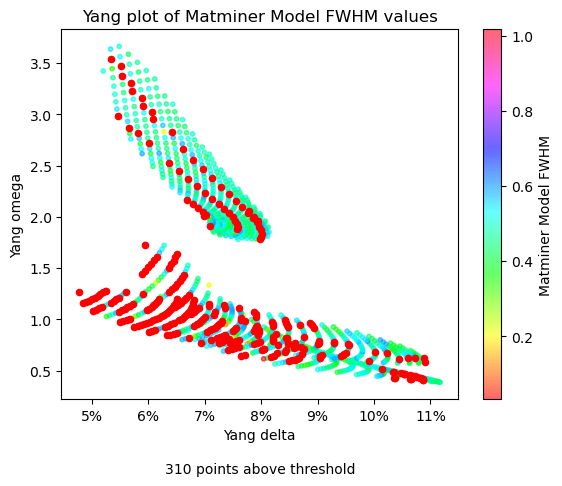

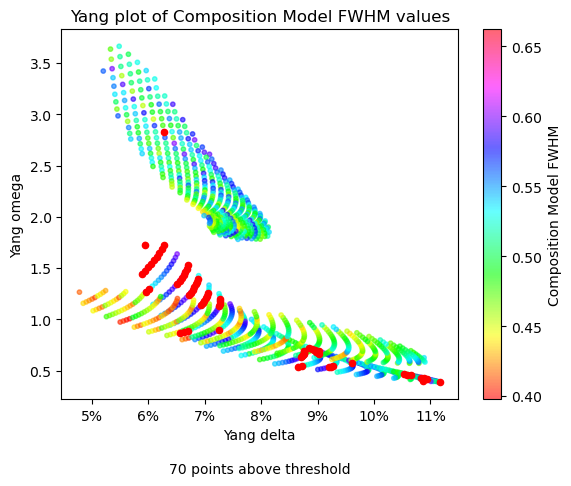

In [34]:
plot_dataframe(final_data, "Matminer Model FWHM", threshold=0.6)
plot_dataframe(final_data, "Composition Model FWHM", threshold=0.6)

## 4.2  Graphs comparing the location of training data versus model predictions

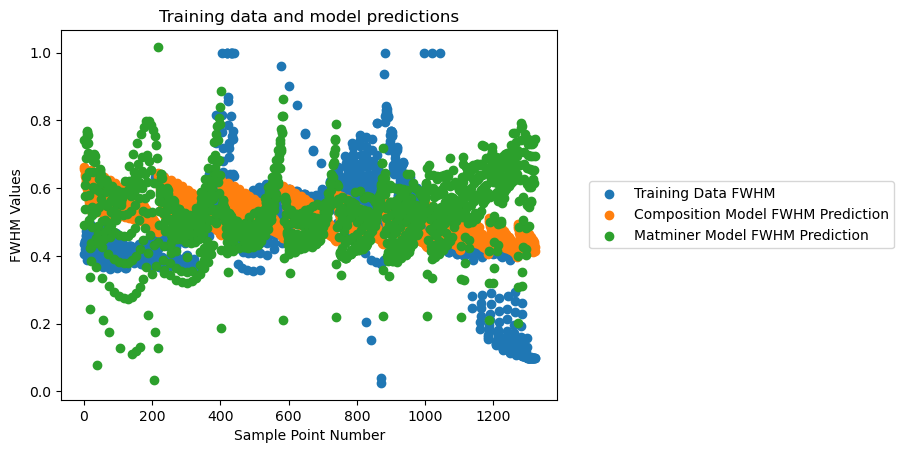

In [35]:
x = np.arange(0,len(combined_data.iloc[:,4]),1)
# Replace negative FWHM predictions from matminer model, to facilitate ease of graphing
matminerfwhm = final_data['Matminer Model FWHM'].where(final_data['Matminer Model FWHM'] >= 0)
fig, ax = plt.subplots()
# Plot FWHM values
ax.scatter(x, combined_data.iloc[:,4], label='Training Data FWHM')
ax.scatter(x, final_data['Composition Model FWHM'], label='Composition Model FWHM Prediction')
ax.scatter(x, matminerfwhm, label='Matminer Model FWHM Prediction')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_xlabel('Sample Point Number')
ax.set_ylabel('FWHM Values')
ax.set_title('Training data and model predictions')
plt.show()

## 4.3 Comparison with Yang heuristic

The region on the Yang plot that may correspond to metallic glasses is based off the following figure from the course notes:
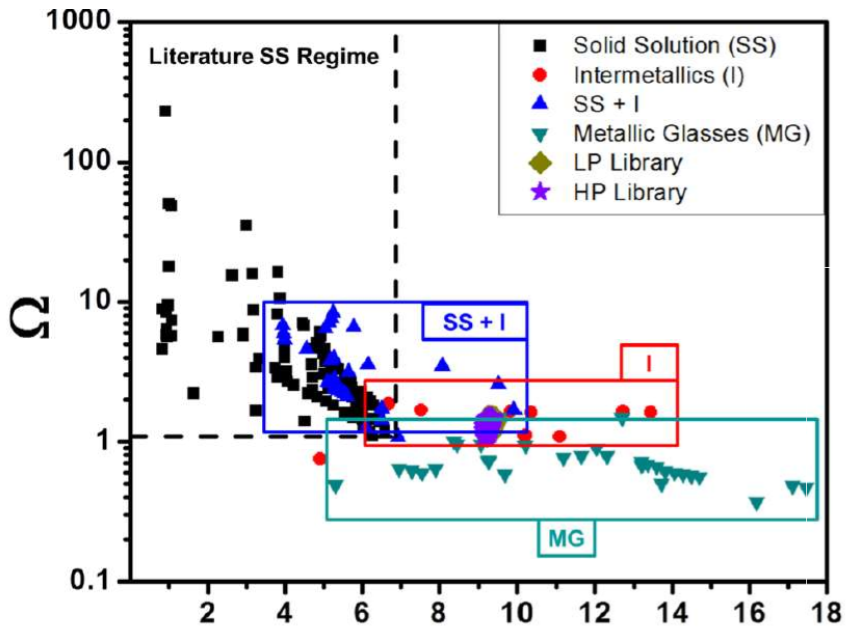

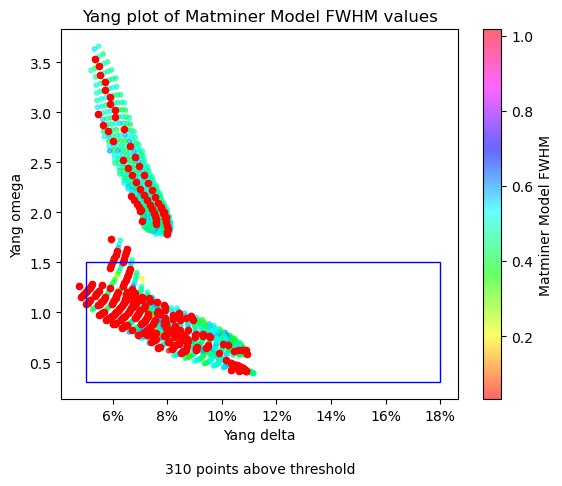

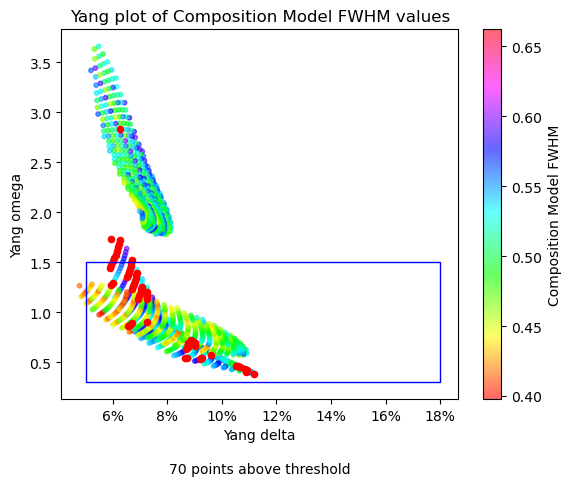

In [36]:
thresh = 0.6
plot_dataframe(final_data, "Matminer Model FWHM", threshold=thresh, overlay_rect=True)
plot_dataframe(final_data, "Composition Model FWHM", threshold=thresh, overlay_rect=True)

# 5.0 Summary

Generally, the MatMiner model trained on composition, Miedema potentials and Yang Solid Solution parameters appears to be the most "reasonable" model. As shown in the random-CV parity plot in Section 3.2.2, the matminer model is able to generalize reasonable well to unseen data, which is evident from its approximate R<sup>2</sup> = 0.78 and MSE = 0.005582 on its test set. In comparison, the composition model had an R<sup>2</sup> = 0.22 and MSE = 0.019344 (Section 2.1.1), which indicates that its generalizability is much poorer. As a result, the MatMiner model appears to be the model that would provide more reasonable predictions of the quaternary system. This is further suggested by the graph in Section 4.2, in which the MatMiner model predictions of the quaternary system more closely resemble that of the known FWHM values in the training data.

Considering the predictions of the models against the Yang heuristic, as shown in Section 4.3, it appears that the predictions of these models are somewhat physical. This is because, in general, values that exceed the threshold FWHM value for potential metallic glass formation are located within the metallic glass regime set by Yang (i.e. having a Yang delta between 5-18 and Yang omega between 0.2 and 1.5, as based off the lecture material). Since many of the points still lie outside of this region, these models' predictions are not completely physically grounded.

Calculating new features from thermodynamics could improve the performance of these models. For example, including the enthalpies and entropies of mixing of alloying elements could help factor in the feasibility solid-solution creation, which in turn could inform how likely a certain alloy composition will form a stable structure (that can eventaully form a metallic glass).

There was significant variance in the validation statistics you observed between random CV and LOCO-CV. In general, LOCO-CV performed significantly worse than random CV. The parity plots in Section 2.1.1 reveal that the model consistently overestimates the value of the FWHM on the test set during LOCO CV. This is further evident the last two figures in Section 2.1.1 (FWHM vs Sample Number graphs). This variance may have arose because Leave One Cluster Out cross-validation poorly splits the data evenly between the training and test sets. For example, it may be that a certain ternary alloy used for testing in LOCO CV may have higher FWHM values than the other two ternary alloy systems that constitute the training set. Such uneven distribution of values would have hindered the model's test performance.

Predictions of glass versus not-glass appear to be sensitive with respect to the chosen MaxFWHM. For example, when a threshold value of 0.6 was applied, 310 points from the MatMiner model were above the threshold while there were only 70 from the composition model. When this threshold was lowered to 0.5, this difference between the two models decreased significantly: 794 points above the threshold from the MatMiner model and 756 from the composition model. Such sensitivity indicates that the FWHM values predicted by these models should be accepted with caution.